In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from scipy.stats import spearmanr
from statsmodels.graphics.tsaplots import plot_acf
import itertools
from itertools import product
import warnings
warnings.filterwarnings('ignore')  # 关闭所有警告

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [2]:
# 读取 Excel 文件
file_path = 'data.xlsx'

# 查看文件内所有sheet名，确认需要读取的sheet
xls = pd.ExcelFile(file_path)
print("Sheet names:", xls.sheet_names)

Sheet names: ['收盘价', '自由流通换手率']


In [3]:
# 读取 sheet1
df = pd.read_excel(file_path, sheet_name='收盘价')

In [4]:
# 将第一列（日期列）重命名为 'date'
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# 将 'date' 转换为 datetime 格式
df['date'] = pd.to_datetime(df['date'])

# 设置为 index
df = df.set_index('date')

# 检查结果
print(df.head())
print(df.index)

               50收益  中证1000全收益     800收益
date                                    
2005-01-04  835.130    989.984  983.8953
2005-01-05  839.529   1013.583  995.5764
2005-01-06  830.513   1005.466  986.2162
2005-01-07  831.641   1011.740  987.6929
2005-01-10  841.102   1023.638  997.1864
DatetimeIndex(['2005-01-04', '2005-01-05', '2005-01-06', '2005-01-07',
               '2005-01-10', '2005-01-11', '2005-01-12', '2005-01-13',
               '2005-01-14', '2005-01-17',
               ...
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19',
               '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
               '2025-06-26', '2025-06-27'],
              dtype='datetime64[ns]', name='date', length=4974, freq=None)


## 布林带策略

In [5]:
def bollinger_reversal_strategy_monthly(df, window=40, num_std=2, min_large_weight=0.5):
    """
    布林带反转大小盘切换策略（月度调仓版）

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列（收盘价）
    - window: int，布林带计算窗口
    - num_std: float，标准差倍数
    - min_large_weight: float，大盘最小配置比例

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列
    """

    # === 1) 计算小盘指数的布林带 ===
    price = df['中证1000全收益']
    rolling_mean = price.rolling(window).mean()
    rolling_std = price.rolling(window).std()

    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std

    # === 2) 提取每月最后一个交易日 ===
    month_end_dates = df.resample('M').last().index

    # === 3) 初始化仓位 ===
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    # 初始默认仓位
    current_pos_50 = min_large_weight
    current_pos_1000 = 1 - min_large_weight

    # === 4) 根据信号更新仓位 ===
    for date in df.index:
        if date in month_end_dates:
            signal_date = df.index[df.index.get_loc(date) - 1]
            if price.loc[signal_date] < lower_band.loc[signal_date]:
                # 小盘超跌，买入小盘
                current_pos_50 = 0
                current_pos_1000 = 1
            elif price.loc[date] > upper_band.loc[date]:
                # 小盘超涨，买入大盘
                current_pos_50 = 1
                current_pos_1000 = 0
            else:
                # 无信号，维持 min_large_weight 配置
                current_pos_50 = min_large_weight
                current_pos_1000 = 1 - min_large_weight

            # 归一化
            total = current_pos_50 + current_pos_1000
            current_pos_50 /= total
            current_pos_1000 /= total

        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df

回测

In [6]:
# 获取策略每日仓位
position_df = bollinger_reversal_strategy_monthly(df)

# =============================
# 计算每日组合收益率
# =============================
returns_50 = df['50收益'].pct_change()
returns_1000 = df['中证1000全收益'].pct_change()
portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# =============================
# 计算净值与超额净值曲线
# =============================
portfolio_nav = (1 + portfolio_returns).cumprod()
benchmark_nav = df['800收益'] / df['800收益'].iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# =============================
# 计算回测指标
# =============================
annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

# =============================
# 输出结果
# =============================
print(f"【回测指标】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")

【回测指标】
年化收益率: 10.55%
年化波动率: 25.89%
夏普比率: 0.41
最大回撤: -71.08%
Calmar Ratio: 0.15


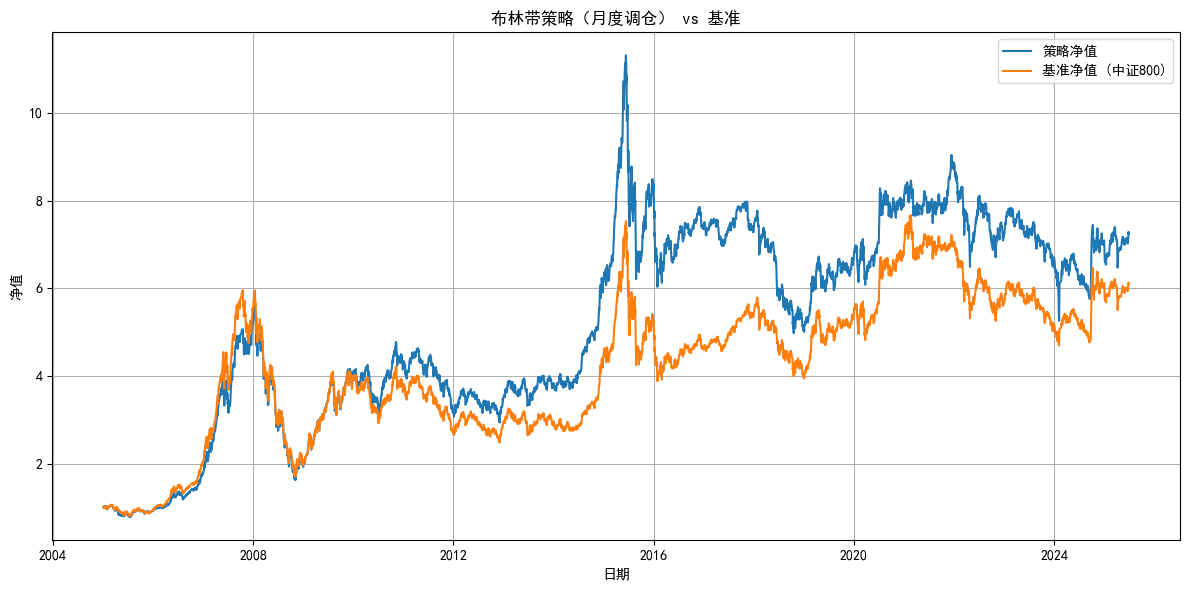

In [7]:
# 绘制净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav, label='策略净值')
plt.plot(benchmark_nav, label='基准净值 (中证800)')
plt.title('布林带策略（月度调仓） vs 基准')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

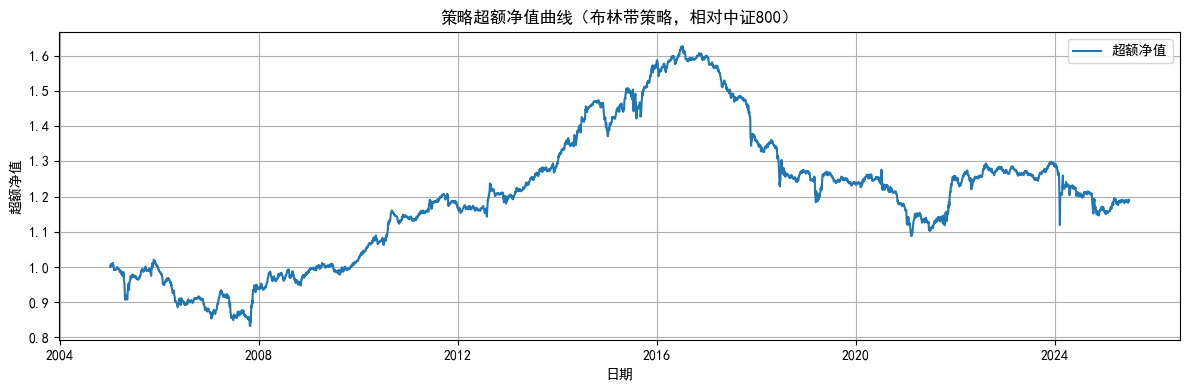

In [8]:
# 绘制超额净值曲线
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='超额净值')
plt.title('策略超额净值曲线（布林带策略，相对中证800）')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

参数优化

In [9]:
# =============================
# 数据切分
# =============================

split_index_train = int(len(df) * 0.65)
split_index_val = int(len(df) * 0.8)

df_train = df.iloc[:split_index_train]
df_val = df.iloc[split_index_train:split_index_val]  # 验证集（测试集1）
df_test = df.iloc[split_index_val:]  # 测试集2

# =============================
# 参数范围
# =============================

window_range = [10, 20, 30, 40, 50, 60]
num_std_range = [1.0, 1.5, 2.0, 2.5, 3.0]

# =============================
# Grid Search on Training Set
# =============================

results = []

for window, num_std in itertools.product(window_range, num_std_range):
    
    # 获取策略仓位（在训练集上）
    position_df = bollinger_reversal_strategy_monthly(
        df_train,
        window=window,
        num_std=num_std
    )
    
    # 计算组合收益率
    returns_50 = df_train['50收益'].pct_change()
    returns_1000 = df_train['中证1000全收益'].pct_change()
    portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
    portfolio_returns = portfolio_returns.fillna(0)
    
    # 计算净值曲线
    portfolio_nav = (1 + portfolio_returns).cumprod()
    
    # 计算指标
    annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # 存储结果
    results.append({
        'window': window,
        'num_std': num_std,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    })

# =============================
# 输出 Top 10
# =============================

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='calmar_ratio', ascending=False)

print("【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】")
print(results_df_sorted.head(10))

【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】
    window  num_std  annual_return  annual_vol  sharpe_ratio  max_drawdown  \
16      40      1.5       0.172442    0.286263      0.602389     -0.694778   
12      30      2.0       0.164478    0.286311      0.574473     -0.710822   
17      40      2.0       0.163383    0.283506      0.576294     -0.710822   
25      60      1.0       0.162620    0.296859      0.547801     -0.707733   
21      50      1.5       0.156712    0.285326      0.549238     -0.694778   
11      30      1.5       0.157018    0.288805      0.543681     -0.712292   
6       20      1.5       0.156490    0.288758      0.541941     -0.710822   
18      40      2.5       0.156109    0.281577      0.554408     -0.710822   
20      50      1.0       0.157482    0.294711      0.534361     -0.720544   
22      50      2.0       0.153486    0.282473      0.543365     -0.710822   

    calmar_ratio  
16      0.248197  
12      0.231391  
17      0.229850  
25      0.229775  
21      0.

In [10]:
# =============================
# 验证集（测试集1）评估
# =============================

best_params = results_df_sorted.iloc[0]

position_val = bollinger_reversal_strategy_monthly(
    df_val,
    window=int(best_params['window']),
    num_std=best_params['num_std']
)

returns_50_val = df_val['50收益'].pct_change()
returns_1000_val = df_val['中证1000全收益'].pct_change()
portfolio_returns_val = position_val['position_50'] * returns_50_val + position_val['position_1000'] * returns_1000_val
portfolio_returns_val = portfolio_returns_val.fillna(0)
portfolio_nav_val = (1 + portfolio_returns_val).cumprod()

annual_return_val = portfolio_nav_val.iloc[-1] ** (252 / len(portfolio_nav_val)) - 1
annual_vol_val = portfolio_returns_val.std() * np.sqrt(252)
sharpe_ratio_val = annual_return_val / annual_vol_val
max_drawdown_val = (portfolio_nav_val / portfolio_nav_val.cummax() - 1).min()
calmar_ratio_val = annual_return_val / abs(max_drawdown_val)

print("\n【验证集（测试集1）表现】")
print(f"年化收益率: {annual_return_val:.2%}")
print(f"年化波动率: {annual_vol_val:.2%}")
print(f"夏普比率: {sharpe_ratio_val:.2f}")
print(f"最大回撤: {max_drawdown_val:.2%}")
print(f"Calmar Ratio: {calmar_ratio_val:.2f}")


【验证集（测试集1）表现】
年化收益率: 4.51%
年化波动率: 21.74%
夏普比率: 0.21
最大回撤: -25.44%
Calmar Ratio: 0.18


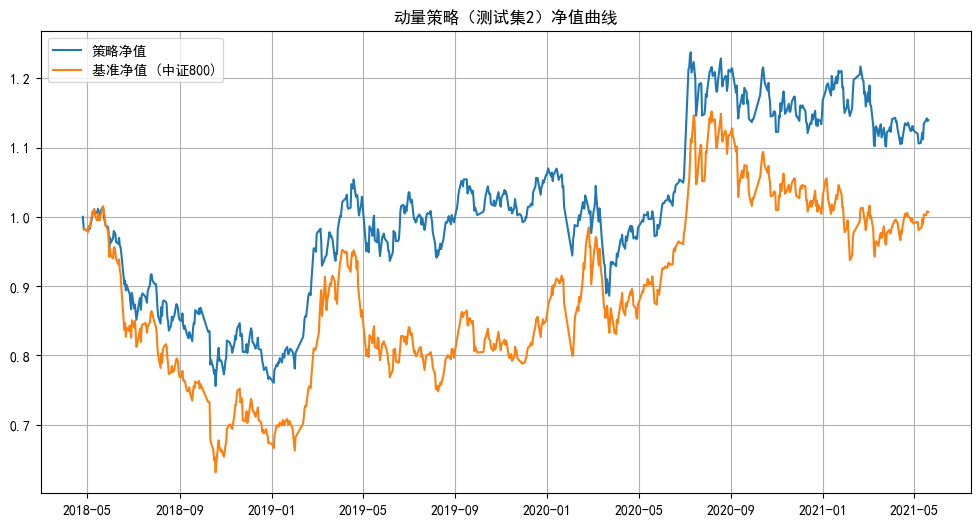

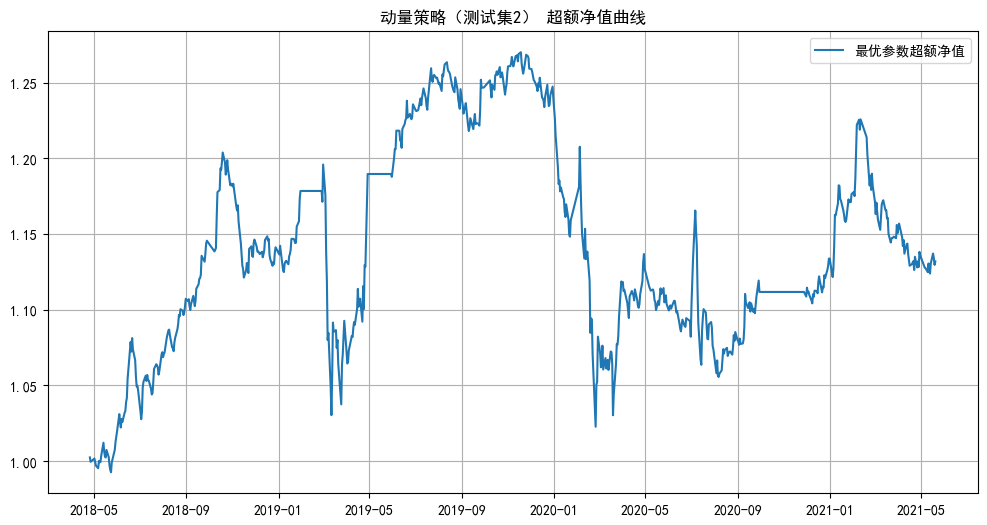

In [11]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_val = (1 + returns_1000_val).cumprod()

# 计算超额净值曲线
excess_nav_val = portfolio_nav_val / benchmark_nav_val


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_val.index, portfolio_nav_val, label='策略净值')
plt.plot(benchmark_nav_val.index, benchmark_nav_val, label='基准净值 (中证800)')
plt.title('动量策略（测试集2）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_val.index, excess_nav_val, label='最优参数超额净值')
plt.title('动量策略（测试集2） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# =============================
# 测试集2 评估
# =============================

position_test2 = bollinger_reversal_strategy_monthly(
    df_test,
    window=int(best_params['window']),
    num_std=best_params['num_std']
)

returns_50_test2 = df_test['50收益'].pct_change()
returns_1000_test2 = df_test['中证1000全收益'].pct_change()
portfolio_returns_test2 = position_test2['position_50'] * returns_50_test2 + position_test2['position_1000'] * returns_1000_test2
portfolio_returns_test2 = portfolio_returns_test2.fillna(0)
portfolio_nav_test2 = (1 + portfolio_returns_test2).cumprod()

annual_return_test2 = portfolio_nav_test2.iloc[-1] ** (252 / len(portfolio_nav_test2)) - 1
annual_vol_test2 = portfolio_returns_test2.std() * np.sqrt(252)
sharpe_ratio_test2 = annual_return_test2 / annual_vol_test2
max_drawdown_test2 = (portfolio_nav_test2 / portfolio_nav_test2.cummax() - 1).min()
calmar_ratio_test2 = annual_return_test2 / abs(max_drawdown_test2)

print("\n【测试集2（最终测试集）表现】")
print(f"年化收益率: {annual_return_test2:.2%}")
print(f"年化波动率: {annual_vol_test2:.2%}")
print(f"夏普比率: {sharpe_ratio_test2:.2f}")
print(f"最大回撤: {max_drawdown_test2:.2%}")
print(f"Calmar Ratio: {calmar_ratio_test2:.2f}")


【测试集2（最终测试集）表现】
年化收益率: -0.24%
年化波动率: 19.69%
夏普比率: -0.01
最大回撤: -43.10%
Calmar Ratio: -0.01


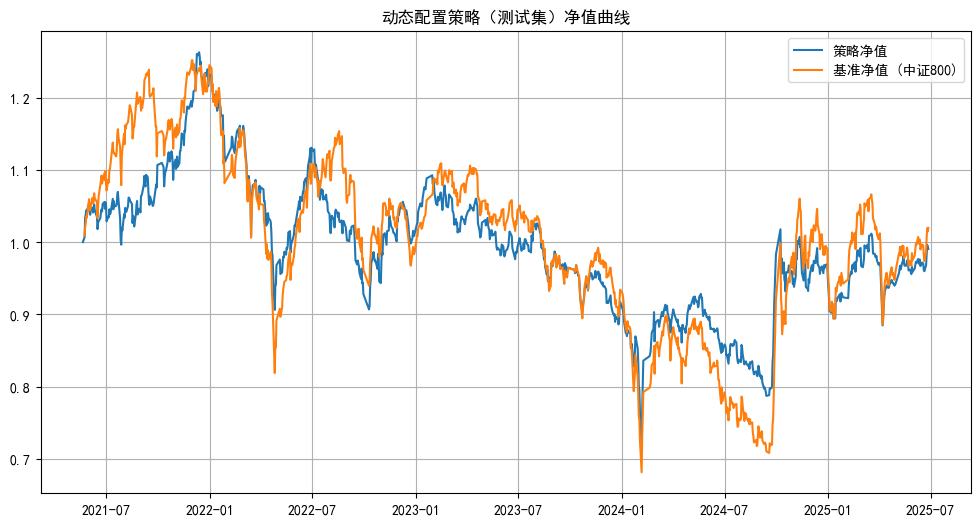

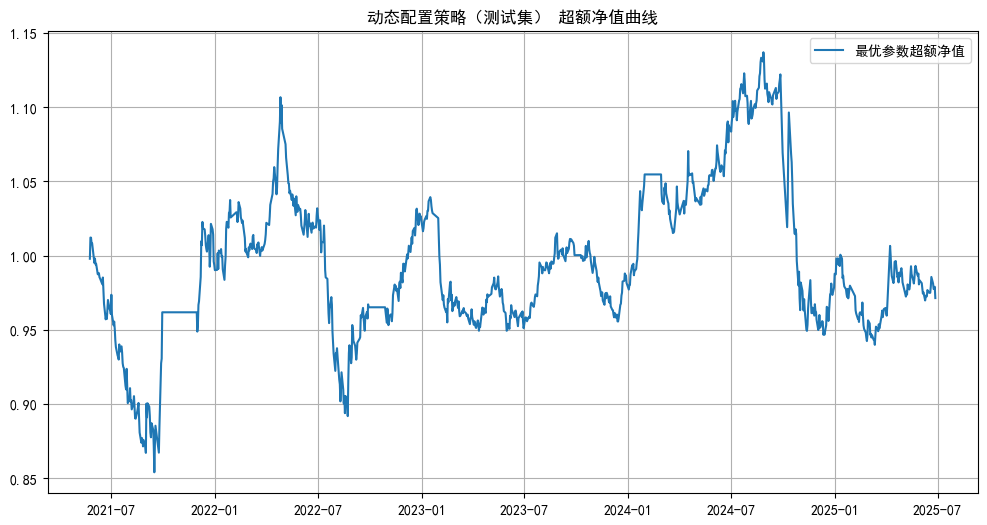

In [13]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_test2 = (1 + returns_1000_test2).cumprod()

# 计算超额净值曲线
excess_nav_test2 = portfolio_nav_test2 / benchmark_nav_test2


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_test2.index, portfolio_nav_test2, label='策略净值')
plt.plot(benchmark_nav_test2.index, benchmark_nav_test2, label='基准净值 (中证800)')
plt.title('动态配置策略（测试集）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_test2.index, excess_nav_test2, label='最优参数超额净值')
plt.title('动态配置策略（测试集） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()